This notebook is an interactive version of [this example](https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_detector.html).

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the text segmentation dataset from ICDAR 2013, available from
https://rrc.cvc.uab.es/?ch=1&com=downloads.

First, we download our dataset.

In [2]:
!pip install matplotlib==3.3.4
!pip install keras_ocr==0.8.6

     |████████████████████████████████| 11.5 MB 28.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 9.5 MB 36.9 MB/s 
     |████████████████████████████████| 895 kB 55.1 MB/s 
     |████████████████████████████████| 603 kB 58.1 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.6-py3-none-any.whl size=42937 sha256=5bf3fab55b9eca92ea09f2db0d0e6612bda3cc2f5910129adaecff0a3f3553de
  Stored in directory: /root/.cache/pip/wheels/19/24/38/2253a2935d4a46d2aedcbcfb9e0cf39ed77140f21e23b83fef
Successfully built keras-ocr


In [1]:
data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

In [2]:
dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


In [3]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
      scale=(1.0, 1.2),
      rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

We can visualize what the samples look like pretty easily.

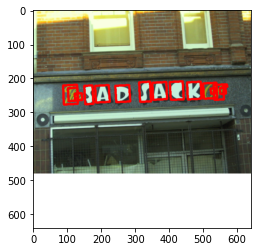

In [4]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

Now we can build the detector and train it.

In [5]:
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=100,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
183/183 [==============================] - 3542s 19s/step - loss: 0.0144 - val_loss: 0.0164
Epoch 2/100
 14/183 [=>............................] - ETA: 51:08 - loss: 0.0076

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-15ad2a9c29f7>", line 21, in <module>
    validation_steps=math.ceil(len(validation) / batch_size)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 2030, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
    result = s

KeyboardInterrupt: ignored

Weights can be loaded into the model attribute of the detector. This is how you can reuse the weights later.

In [ ]:
detector.model.load_weights(os.path.join(data_dir, 'detector_icdar2013.h5'))